In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

seed = 42

In [2]:
X_train_df = pd.read_csv('X_train.csv')
X_test_df = pd.read_csv('X_test.csv')
y_train_df = pd.read_csv('y_train.csv')
y_test_df = pd.read_csv('y_test.csv')

In [3]:
X_train_df

,Day,Month,Seasons,Reason_bin,household_size,has_collegedegree,BMI_bin,boxcox_work_load,Age_bin,ord_dist_bin,ord_tr_exp_bin
0,4,5,0.812500,2.742857,1.136842,0,1.236842,0.582718,0.817708,3,0
1,4,9,0.715789,0.489362,1.136842,0,0.709402,0.582716,0.817708,3,2
2,2,5,0.812500,2.742857,0.857143,1,0.709402,0.582715,0.817708,1,1
3,1,5,0.812500,0.489362,0.857143,1,0.709402,0.582734,0.817708,1,1
4,3,9,0.715789,0.489362,1.136842,0,0.603448,0.582724,0.872727,1,2
...,...,...,...,...,...,...,...,...,...,...,...
551,1,10,0.715789,0.489362,1.136842,0,0.709402,0.582720,0.677419,1,0
552,2,6,1.229508,0.489362,1.136842,0,0.709402,0.582733,0.677419,1,0
553,4,10,0.715789,2.742857,0.548611,1,0.709402,0.582723,0.817708,1,1
554,3,8,1.229508,0.489362,0.857143,0,1.236842,0.582719,0.817708,3,3


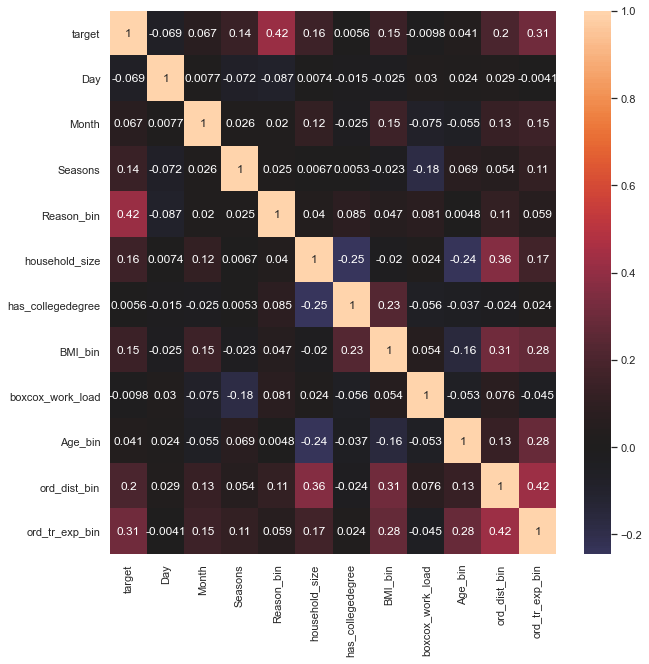

In [4]:
plt.figure(figsize = (10,10))
sns.heatmap(pd.concat([y_train_df, X_train_df], axis = 1).corr(), annot = True, center = 0);

In [5]:
X_train = X_train_df.values
X_test = X_test_df.values

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train_df)
X_test_scaled = sc.transform(X_test_df)

In [6]:
y_train = y_train_df.target.values
y_test = y_test_df.target.values

In [7]:
X_train.shape, X_test.shape

((556, 11), (62, 11))

In [8]:
y_train.shape, y_test.shape

((556,), (62,))

In [9]:
def check_clf_models(Xtrain, ytrain, cv):
    
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    
    from sklearn.linear_model import (
        LogisticRegression,
        LogisticRegressionCV,
        SGDClassifier,
        Perceptron,
        PassiveAggressiveClassifier,
        RidgeClassifier, 
        RidgeClassifierCV
    )

    from sklearn.svm import LinearSVC, SVC, NuSVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import  GaussianNB, BernoulliNB
    from sklearn.neural_network import MLPClassifier
    from sklearn.gaussian_process import GaussianProcessClassifier

    from sklearn import metrics

    models = [
        LogisticRegression(),
        LogisticRegressionCV(cv=5),
        SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
        Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
        PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
        RidgeClassifier(),
        RidgeClassifierCV(cv=5),
        LinearSVC(loss = 'hinge'),
        SVC(kernel = 'rbf'),
        NuSVC(),
        KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
        GaussianNB(), 
        BernoulliNB(),
        MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2),
        GaussianProcessClassifier()
    ]

    final_f1_score = []
    final_score = []
    final_score_std = []
    final_roc_auc_score = []
    final_mcc_score = []
    model_names = []

    for model in models:
        pipe = Pipeline(steps = [('scaler', StandardScaler()), (type(model).__name__, model)])
        score = [] 
        f1_score = []
        roc_auc_score = []
        mcc_score = []
        fold_no = 1 
        for train_index, test_index in cv.split(Xtrain, ytrain): 
            X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index] 
            y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index] 
            pipe.fit(X_train_kfold, y_train_kfold) 
            y_pred = pipe.predict(X_val_kfold)
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
            mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

            if hasattr(model, "predict_proba"):
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           pipe.predict_proba(X_val_kfold)[:, 1]))
            else: 
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           pipe.decision_function(X_val_kfold)))

            fold_no += 1
        final_score.append(np.round(np.mean(score)*100,3))
        final_score_std.append(np.round(np.std(score)*100,3))
        final_f1_score.append(np.round(np.mean(f1_score)*100,3))
        final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
        final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
        model_names.append(type(model).__name__)

#Using Ensemble Models

    from sklearn.tree import DecisionTreeClassifier
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.experimental import enable_hist_gradient_boosting
    
    from sklearn.ensemble import (
        RandomForestClassifier, 
        AdaBoostClassifier, 
        GradientBoostingClassifier, 
        ExtraTreesClassifier, 
        IsolationForest, 
        BaggingClassifier, 
        HistGradientBoostingClassifier
    )
    
    from imblearn.ensemble import (
        EasyEnsembleClassifier, 
        RUSBoostClassifier, 
        BalancedBaggingClassifier, 
        BalancedRandomForestClassifier 
    )
    
    tree_models = [
        DecisionTreeClassifier(criterion = 'entropy', max_depth = 6),
        RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
        XGBClassifier(use_label_encoder=False, eval_metric = 'error'), 
        CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1'), 
        LGBMClassifier(), 
        AdaBoostClassifier(), 
        GradientBoostingClassifier(), 
        BaggingClassifier(), 
        ExtraTreesClassifier(), 
        HistGradientBoostingClassifier(), 
        EasyEnsembleClassifier(), 
        RUSBoostClassifier(), 
        BalancedBaggingClassifier(), 
        BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)
    ]

    for model in tree_models:
        score = [] 
        f1_score = []
        mcc_score = []
        fold_no = 1 
        for train_index, test_index in cv.split(Xtrain,ytrain): 
            X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index] 
            y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index] 
            classifier = model 
            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
            roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
            mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))
            
            fold_no += 1
        final_score.append(np.round(np.mean(score)*100,3))
        final_score_std.append(np.round(np.std(score)*100,3))
        final_f1_score.append(np.round(np.mean(f1_score)*100,3))
        final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
        final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
        model_names.append(type(model).__name__)
        

    df = pd.DataFrame({
            'Models': model_names, 
            'Accuracy %': final_score, 
            'Acc_STD %': final_score_std, 
            'F1_Score %':final_f1_score,
            'ROC_AUC_Score %' :final_roc_auc_score, 
            'MCC_Score %': final_mcc_score
        }).sort_values('F1_Score %', ascending = False, ignore_index = True).style.\
                                                            highlight_max(color = 'green')
        
    return df

In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

In [11]:
check_clf_models(X_train, y_train, cv=skf)

,Models,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,BalancedRandomForestClassifier,75.718000,3.340000,73.339000,79.883000,51.379000
1,RandomForestClassifier,75.185000,4.907000,71.079000,78.579000,49.779000
2,EasyEnsembleClassifier,73.383000,7.119000,71.074000,79.650000,46.964000
3,LGBMClassifier,73.380000,4.989000,70.140000,79.049000,46.227000
4,SVC,74.110000,4.040000,70.030000,79.756000,47.774000
5,GradientBoostingClassifier,73.377000,5.006000,70.026000,79.588000,46.295000
6,RUSBoostClassifier,72.844000,5.975000,69.963000,79.713000,45.602000
7,DecisionTreeClassifier,74.821000,7.495000,69.467000,76.873000,48.726000
8,HistGradientBoostingClassifier,72.477000,5.566000,69.087000,79.513000,44.483000
9,CatBoostClassifier,72.659000,2.903000,69.070000,78.930000,44.709000


# Feature Selection

### Statistical Methods

Need to corroborate that the assumptions are true for:

1) linear relationship between target and features,
2) features follow a normal distribution

#### Mutual Information

Index(['Month', 'Seasons', 'Reason_bin', 'BMI_bin', 'boxcox_work_load',
       'ord_tr_exp_bin'],
      dtype='object')

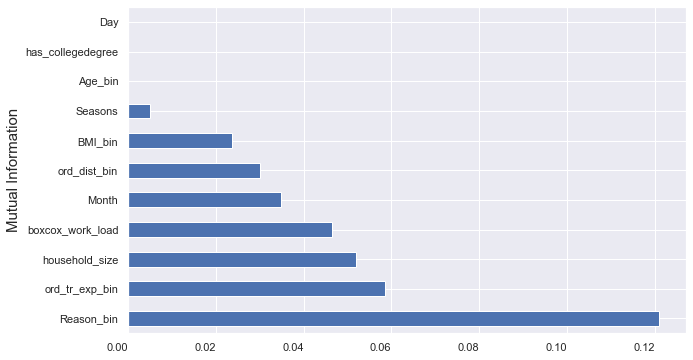

In [12]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile

mi = mutual_info_classif(X_train_df, y_train_df.target)

# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_train_df.columns
mi.sort_values(ascending=False).plot.barh(figsize=(10, 6));
plt.xticks(ha = 'right')
plt.ylabel('Mutual Information');

# select features
sel_ = SelectKBest(mutual_info_classif, k=6).fit(X_train_df, y_train_df.target)

# display features

mi_feat = X_train_df.columns[sel_.get_support()]
mi_feat

#### Chi2

Index(['Day', 'Month', 'Reason_bin', 'household_size', 'ord_dist_bin',
       'ord_tr_exp_bin'],
      dtype='object')

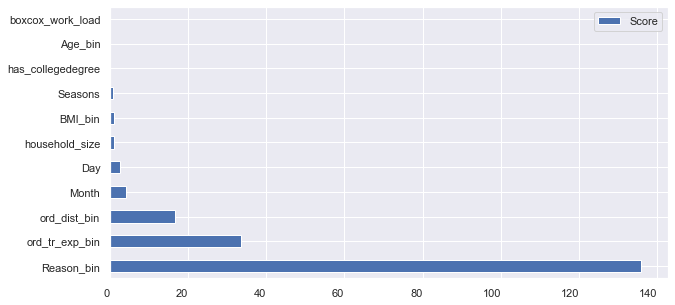

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

sel_ = SelectKBest(chi2, k=6).fit(X_train_df, y_train_df.target)

pd.DataFrame({'Score': sel_.scores_}, index=X_train_df.columns).\
sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5));
plt.xticks(ha='right');

chi2_feat = X_train_df.columns[sel_.get_support()]
chi2_feat

#### ANOVA

Index(['Seasons', 'Reason_bin', 'household_size', 'BMI_bin', 'ord_dist_bin',
       'ord_tr_exp_bin'],
      dtype='object')

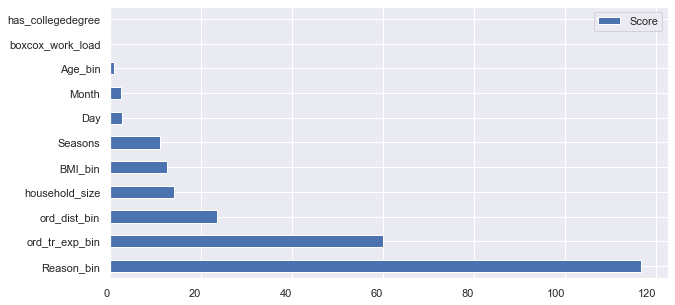

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif #or f_regression for regression. #ANOVA

sel_ = SelectKBest(f_classif, k=6).fit(X_train_df, y_train_df.target)
pd.DataFrame({'Score': sel_.scores_}, index=X_train_df.columns).\
sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5));
plt.xticks(ha='right');

anova_feat = X_train_df.columns[sel_.get_support()]
anova_feat

### Feature importance using Random Forest

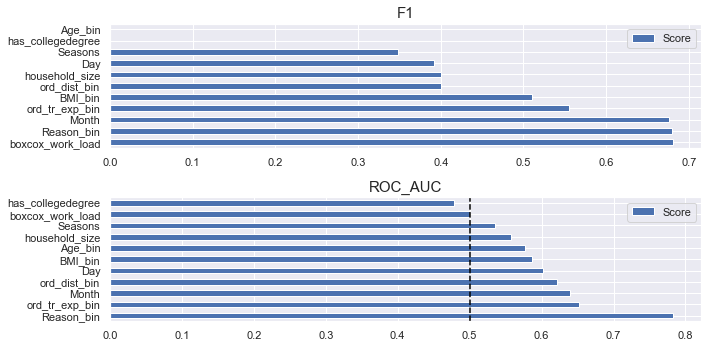

In [15]:
from sklearn.ensemble import RandomForestClassifier

# here we store the roc-auc values
f1_values = []
roc_auc_values = []

# iterate over each feature in the dataset
for feature in X_train_df.columns:
    # train a decision tree classifier
    clf = RandomForestClassifier(n_estimators=100, max_depth = 6, criterion='entropy')
    clf.fit(X_train_df.loc[:,feature].to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict(X_test_df.loc[:,feature].to_frame())
    y_probs = clf.predict_proba(X_test_df.loc[:,feature].to_frame())

    # calculate and store the roc-auc
    f1_values.append(metrics.f1_score(y_test, y_scored))
    roc_auc_values.append(metrics.roc_auc_score(y_test, y_probs[:,1]))
    

fig, ax = plt.subplots(2,1, figsize = (25,25))

pd.DataFrame({'Score': f1_values}, index=X_train_df.columns).\
sort_values('Score', ascending = False).plot(kind = 'barh', ax = ax[0], figsize = (10,5), title = 'F1');

pd.DataFrame({'Score': roc_auc_values}, index=X_train_df.columns).\
sort_values('Score', ascending = False).plot(kind = 'barh', ax = ax[1], figsize = (10,5), title='ROC_AUC');

plt.axvline(x=0.5, color = 'black', ls = '--' )
plt.tight_layout()

### Wrapper methods

In [16]:
#BAckward Elimination

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.ensemble import BalancedRandomForestClassifier 

import time
start_time = time.time()

model = BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)

back = SFS(model, k_features=(1,11),forward=False, floating=False, scoring = 'f1', 
           cv=StratifiedKFold(n_splits=5, random_state=seed, shuffle = True))

back.fit(X_train_df, y_train_df)

print(f'elapsed time: {(time.time() - start_time)/60} min')
print()
print(f'Best Score: {np.round(back.k_score_*100,3)} %')

                                       
back.k_feature_names_

elapsed time: 1.2420036713282268 min

Best Score: 76.073 %


('Seasons',
 'Reason_bin',
 'household_size',
 'BMI_bin',
 'boxcox_work_load',
 'Age_bin',
 'ord_dist_bin')

In [17]:
#Forward Elimination

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import time
start_time = time.time()

model = BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)

front = SFS(model, k_features=(1,11), scoring = 'f1', forward=True, 
            floating=False, cv=StratifiedKFold(n_splits=5, random_state=seed, shuffle = True))

front.fit(X_train_df, y_train_df)

print(f'elapsed time: {(time.time() - start_time)/60} min')
print()    
print(f'Best Score: {np.round(front.k_score_*100,3)} %')

front.k_feature_names_

elapsed time: 1.2747763991355896 min

Best Score: 77.296 %


('Reason_bin', 'household_size', 'Age_bin', 'ord_tr_exp_bin')

In [18]:
#Bidirectional Elimination

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import time
start_time = time.time()

model = BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)

bi = SFS(model, k_features=(1,11), scoring = 'f1', forward=True, 
         floating=True, cv=StratifiedKFold(n_splits=5, random_state=seed, shuffle = True))

bi.fit(X_train_df, y_train_df)

print(f'elapsed time: {(time.time() - start_time)/60} min')
print() 
print(f'Best Score: {np.round(bi.k_score_*100,3)} %')

bi.k_feature_names_

elapsed time: 4.885308468341828 min

Best Score: 77.532 %


('Reason_bin', 'household_size', 'Age_bin', 'ord_tr_exp_bin')

### Embedded methods

Features Selected from Lasso Regularization: ['Seasons', 'Reason_bin', 'household_size', 'BMI_bin', 'ord_tr_exp_bin']


,Features,Score
3,Reason_bin,0.090297
10,ord_tr_exp_bin,0.045085
4,household_size,0.006213
2,Seasons,0.006141
6,BMI_bin,0.002917
8,Age_bin,-0.000009
9,ord_dist_bin,-0.000019
1,Month,-0.000020
7,boxcox_work_load,-0.000226
5,has_collegedegree,-0.000392


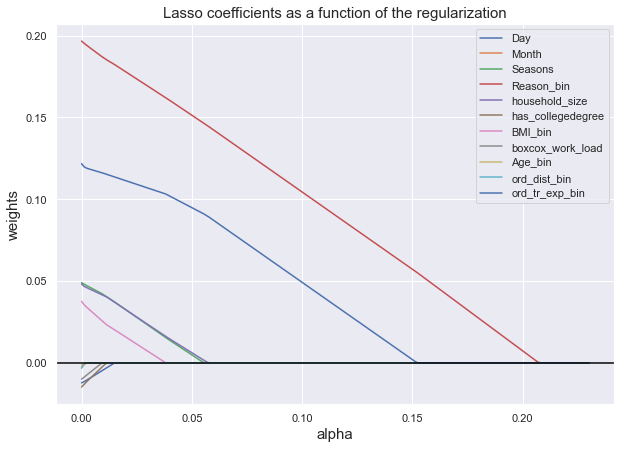

In [19]:
#Using LASSO regularization 

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.linspace(-0.0,0.23,n_alphas)#10**np.linspace(10,-2,n_alphas)*0.5

coefs = []
for a in alphas:
    lasso = Pipeline(steps = [
        ('scaler', StandardScaler()), 
        ('lasso', linear_model.Lasso(alpha=a, fit_intercept=False))
    ])
    
    lasso.fit(X_train_df, y_train_df)
    coefs.append(lasso.named_steps.lasso.coef_)

# #############################################################################
# Display results
label = X_train_df.columns

plt.figure(figsize = (10,7))
ax = plt.gca()
ax.plot(alphas, coefs);

plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(label);

coef_df = pd.DataFrame({'Features': label, 'Score':np.mean(coefs,0)})

lasso_feat = [i for i in coef_df[coef_df['Score']>0]['Features']]
print(f'Features Selected from Lasso Regularization: {lasso_feat}')
coef_df.sort_values('Score', ascending = False)

Features ranked according to Random Forests Feature Importance: Index(['Reason_bin', 'boxcox_work_load', 'ord_tr_exp_bin', 'Month',
       'ord_dist_bin'],
      dtype='object')


,Score
Day,0.062280
Month,0.076334
Seasons,0.047619
Reason_bin,0.305033
household_size,0.056775
has_collegedegree,0.015846
BMI_bin,0.046412
boxcox_work_load,0.137243
Age_bin,0.058078
ord_dist_bin,0.065619


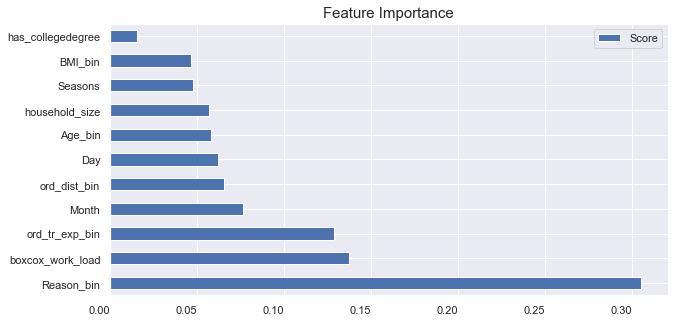

In [20]:
#Feature Importance

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth = 6, criterion='entropy')

rf.fit(X_train_df, y_train_df)

fi_df = pd.DataFrame({'Score': rf.feature_importances_}, index=X_train_df.columns)

fi_df.sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5), 
                                                   title = 'Feature Importance');
plt.xticks(ha='right');

rf_fi_feat = fi_df.sort_values('Score', ascending = False)[:5].index
print(f'Features ranked according to Random Forests Feature Importance: {rf_fi_feat}')

fi_df

### Recursive Feature Elimination

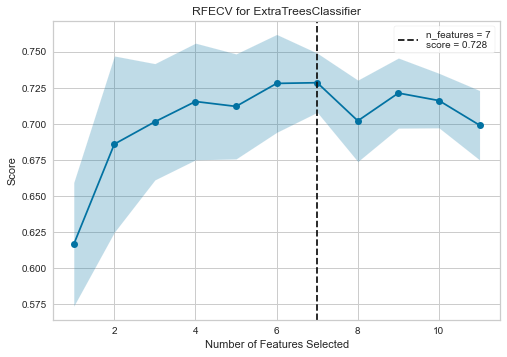

elapsed time: 0.5748545328776041 min

Feature Rankings: [3 1 2 1 1 5 1 4 1 1 1]


In [21]:
from yellowbrick.model_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier

import time
start_time = time.time()

visualizer = RFECV(ExtraTreesClassifier(criterion = 'entropy', max_depth = 6), 
                   cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle = True), 
                   scoring = 'f1')

visualizer.fit(X_train_df, y_train_df)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

print(f'elapsed time: {(time.time() - start_time)/60} min')
print()    
print(f'Feature Rankings: {visualizer.ranking_}')

rfe_feat = [X_train_df.columns[i] for i, x in enumerate(visualizer.ranking_) if x==1]

### Recursive feature addition

elapsed time: 0.10416555404663086 min

Score when using all features: 70.484 %


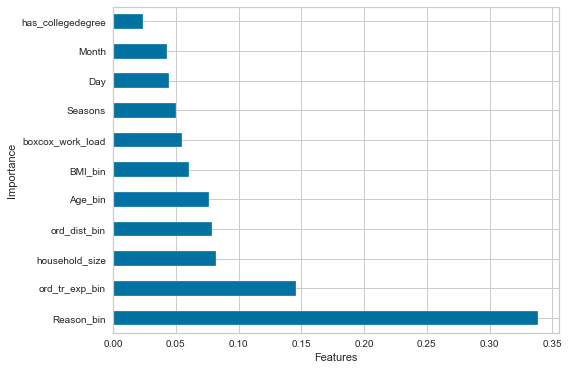

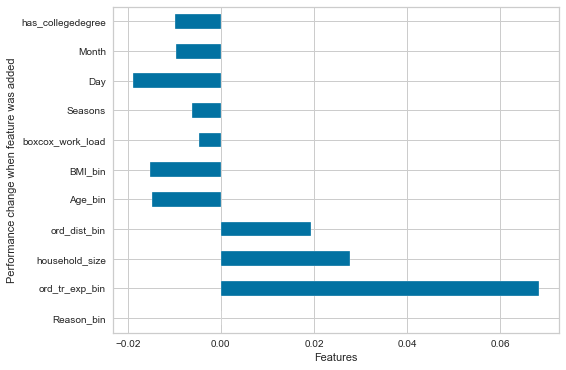

Selected Features: ['Reason_bin', 'household_size', 'ord_dist_bin', 'ord_tr_exp_bin']


In [22]:
from feature_engine.selection import RecursiveFeatureAddition

import time
start_time = time.time()

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='f1',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=5,  # cross-validation
)

rfa.fit(X_train_df, y_train_df)

print(f'elapsed time: {(time.time() - start_time)/60} min')
print() 
print(f'Score when using all features: {np.round(rfa.initial_model_performance_*100,3)} %')

# importance of all features based of initial model
rfa.feature_importances_.plot.barh(figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

pd.Series(rfa.performance_drifts_).plot.barh(figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

rfa_feat = [feat for feat in X_train_df.columns if feat not in rfa.features_to_drop_]

print(f'Selected Features: {rfa_feat}')

elapsed time: 0.022120555241902668 min

Score when using all features: 69.92 %


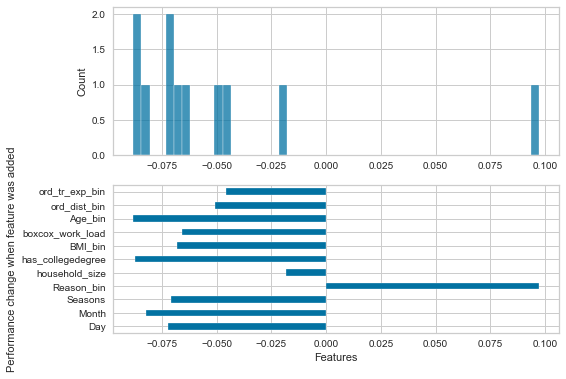

Selected Features: ['Reason_bin', 'household_size', 'ord_tr_exp_bin']


In [23]:
from feature_engine.selection import SelectByShuffling

import time
start_time = time.time()

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

sel_shuff = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=model, # the ML model
    scoring='f1', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=5, # cross validation
    random_state=seed # seed
)

sel_shuff.fit(X_train_df, y_train_df)

print(f'elapsed time: {(time.time() - start_time)/60} min')
print() 
print(f'Score when using all features: {np.round(sel_shuff.initial_model_performance_*100,3)} %')

fig, ax = plt.subplots(2,1)

sns.histplot(sel_shuff.performance_drifts_, bins = 50, ax=ax[0])

pd.Series(sel_shuff.performance_drifts_).plot.barh(figsize=(8,6));
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

sel_shuff_feat = [feat for feat in X_train_df.columns if feat not in sel_shuff.features_to_drop_]

print(f'Selected Features: {sel_shuff_feat}')

## Comparison of all features

In [24]:
selected_features = {
    'mutual_information': mi_feat, 
    'chi_squared': chi2_feat, 
    'ANOVA': anova_feat, 
    'back_elimination': list(back.k_feature_names_), 
    'front_elimination': list(front.k_feature_names_),
    'bidirectional_elimination': list(bi.k_feature_names_),
    'LASSO_regularization': lasso_feat, 
    'Random_Forest_feature_imp': rf_fi_feat, 
    'recursive_feature_elimination': rfe_feat, 
    'recursive_feature_addition': rfa_feat, 
    'select_by_shuffle': sel_shuff_feat
}

In [25]:
def check_features(model, train_X, train_Y, feature_dict, cv):
    
    final_f1_score = []
    final_score = []
    final_score_std = []
    final_roc_auc_score = []
    final_mcc_score = []
    feat_names = []

    for name, feat in feature_dict.items():
        
        Xtrain = train_X.loc[:,feat].values
        ytrain = train_Y.values

        score = [] 
        f1_score = []
        roc_auc_score = []
        mcc_score = []
        fold_no = 1 

        for train_index, test_index in cv.split(Xtrain, ytrain): 
            X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index] 
            y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index] 
            classifier = model 
            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
            roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
            mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

            fold_no += 1

        final_score.append(np.round(np.mean(score)*100,3))
        final_score_std.append(np.round(np.std(score)*100,3))
        final_f1_score.append(np.round(np.mean(f1_score)*100,3))
        final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
        final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
        feat_names.append(name)
    
    df = pd.DataFrame({
        'Features_Select_method': feat_names, 
        'Accuracy %': final_score, 
        'Acc_STD %': final_score_std, 
        'F1_Score %':final_f1_score,
        'ROC_AUC_Score %' :final_roc_auc_score, 
        'MCC_Score %': final_mcc_score
    }).sort_values('F1_Score %', ascending = False, ignore_index = True).style.\
                                                        highlight_max(color = 'green')
        
    return df

In [26]:
model = BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)

skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

check_features(model, X_train_df, y_train_df.target, feature_dict = selected_features, cv = skf)

,Features_Select_method,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,front_elimination,79.685000,3.622000,77.593000,83.696000,59.381000
1,bidirectional_elimination,79.328000,3.446000,77.103000,83.501000,58.636000
2,recursive_feature_addition,78.425000,3.532000,76.091000,83.173000,57.040000
3,select_by_shuffle,77.172000,4.002000,75.705000,82.963000,54.960000
4,LASSO_regularization,76.799000,5.334000,75.162000,82.355000,53.817000
5,ANOVA,77.149000,3.888000,75.022000,82.846000,54.368000
6,back_elimination,76.802000,3.856000,74.469000,83.310000,53.414000
7,recursive_feature_elimination,76.620000,4.149000,74.142000,83.082000,53.202000
8,chi_squared,75.724000,3.921000,73.635000,82.756000,51.551000
9,mutual_information,73.734000,6.903000,71.829000,80.792000,47.837000


Among all the feature selection methods, feature selection by front elimination gave the right features that can help improve the model performance. 

In [27]:
#creating parsimonious train set.
X_train_pars = X_train_df.loc[:, list(front.k_feature_names_)]
X_test_pars = X_test_df.loc[:, list(front.k_feature_names_)]

In [29]:
X_train_pars.to_csv('X_train_pars_df.csv', index= False)
X_test_pars.to_csv('X_test_pars_df.csv', index= False)